# 2. Pre-Processing & Baseline Modeling

## 2.1 Contents <a id='2.1_Contents'></a>
* [2.1 Contents](#2.1_Contents)
* [2.2 Introduction](#2.2)
* [2.3 Imports](#2.3)
* [2.4 Loading Data](#2.4)
* [2.5 Set Options](#2.5)
* [2.6 Pre-Processing](#2.6)
    * [2.6.1 Build Table for Modeling](#2.6.1)
    * [2.6.2 Prepare Table for Modeling](#2.6.2)
    
* [2.7 Initial Model](#2.7)
* [2.8 Additional analysis on coupons users vs. not coupon users](#2.8)
* [2.9 Exports](#2.9)
* [2.10 Discussion & Next Steps](#2.10)


    

## 2.2 Introduction <a id='2.2'></a>

In the last section, 1 Dunnhumby EDA, I did exploratory data analysis on the 8 tables. I cleaned the data, did some initial feature engineering, found how the data were distributed, coupon redemption rates by different demographics, looked at sales patterns and trends, compared transactions with discounts vs no discounts, identified how the campaigns were sent out and responded to, and performed baseline time series analysis. 

In this notebook, I will perform pre-processing to prepare our data for modeling. I am interested primarily in predicting how demographics impact sales trends, so 'sales_value' will be my target feature. 

## 2.3 Imports <a id='2.3'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandasql import sqldf
import pandasql as psql
import sqlite3
from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsRegressor
import os
import pickle
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from matplotlib.lines import Line2D
from statsmodels.stats.outliers_influence import OLSInfluence



## 2.4 Loading Data <a id='2.4'></a>

In [2]:
campaign_desc = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\campaign_desc.csv")
campaign_table = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\campaign_table.csv")
coupon = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\coupon.csv")
coupon_redempt = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\coupon_redempt.csv")
hh_demographic = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\hh_demographic.csv")
product = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\product.csv")
transaction_data = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\transaction_data.csv")
demo_coupon = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\demo_coupon")
demo_no_disc = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\demo_no_disc")
merged_data = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\merged_data")


## 2.5 Set Options <a id='2.5'></a>

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

# Set up my psql
pysql = lambda q: sqldf(q, globals())

## 2.6 Pre-Processing <a id='2.6'></a>

### 1.6.1 Build Table for Modeling  <a id='2.6.1'></a>
Target: sales_value

Features: day, household_key(to remove later), basket_id(to remove later), product_id(?)coupon_disc, retail_disc, coupon_match_disc, amt_paid, demographics

In [4]:
transaction_data

,household_key,basket_id,store_id,day,week_no,trans_time,product_id,sales_value,amt_paid,retail_disc,coupon_disc,coupon_match_disc,day_of_week,hour
0,2375,26984851472,364,1,1,16:31:00,1004906,1.39,0.79,-0.60,0.0,0.0,1,16
1,2375,26984851472,364,1,1,16:31:00,1033142,0.82,0.82,0.00,0.0,0.0,1,16
2,2375,26984851472,364,1,1,16:31:00,1036325,0.99,0.69,-0.30,0.0,0.0,1,16
3,2375,26984851472,364,1,1,16:31:00,1082185,1.21,1.21,0.00,0.0,0.0,1,16
4,2375,26984851472,364,1,1,16:31:00,8160430,1.50,1.11,-0.39,0.0,0.0,1,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2581261,1598,42305362535,3228,711,102,15:20:00,92130,0.99,0.99,0.00,0.0,0.0,4,15
2581262,1598,42305362535,3228,711,102,15:20:00,114102,8.89,8.89,0.00,0.0,0.0,4,15
2581263,1598,42305362535,3228,711,102,15:20:00,133449,6.99,6.99,0.00,0.0,0.0,4,15
2581264,1598,42305362535,3228,711,102,15:20:00,6923644,4.50,4.01,-0.49,0.0,0.0,4,15


First, select the columns from transaction_data that I will use. I will later drop the time, household_key, and basket_id, but I'm keeping them for now

In [5]:
query = """

SELECT day, week_no, household_key, basket_id, sales_value, coupon_disc, coupon_match_disc
FROM transaction_data
ORDER BY day;
"""

transaction_data_selected = psql.sqldf(query, locals())
transaction_data_selected

,day,week_no,household_key,basket_id,sales_value,coupon_disc,coupon_match_disc
0,1,1,2375,26984851472,1.39,0.0,0.0
1,1,1,2375,26984851472,0.82,0.0,0.0
2,1,1,2375,26984851472,0.99,0.0,0.0
3,1,1,2375,26984851472,1.21,0.0,0.0
4,1,1,2375,26984851472,1.50,0.0,0.0
...,...,...,...,...,...,...,...
2581261,711,102,1598,42305362535,0.99,0.0,0.0
2581262,711,102,1598,42305362535,8.89,0.0,0.0
2581263,711,102,1598,42305362535,6.99,0.0,0.0
2581264,711,102,1598,42305362535,4.50,0.0,0.0


In [6]:
transaction_data_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2581266 entries, 0 to 2581265
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   day                int64  
 1   week_no            int64  
 2   household_key      int64  
 3   basket_id          int64  
 4   sales_value        float64
 5   coupon_disc        float64
 6   coupon_match_disc  float64
dtypes: float64(3), int64(4)
memory usage: 137.9 MB


Join the transaction data with the demographic data, only keeping transactions that have household in demographic table. As I am interested in how demographics contribute towards sales values, I can leave out the transactions that do not correspond to a household with demographics details registered.

In [7]:
query = """
SELECT t.*, h.age_desc AS age, h.marital_status, h.income_desc AS income, h.homeowner_desc AS homeowner, h.hh_comp_desc AS hh_comp, h.household_size_desc AS hh_size, h.kid_category_desc AS kids
FROM transaction_data_selected as t
INNER JOIN hh_demographic as h
ON t.household_key = h.household_key
ORDER BY day;
"""

transaction_demo = psql.sqldf(query, locals())

In [8]:
transaction_demo.tail()

,day,week_no,household_key,basket_id,sales_value,coupon_disc,coupon_match_disc,age,marital_status,income,homeowner,hh_comp,hh_size,kids
1419126,711,102,1369,42302712189,1.29,0.0,0.0,25-34,Single,Under 15K,Probable Renter,Single Male,1,None/Unknown
1419127,711,102,1369,42302712189,1.69,0.0,0.0,25-34,Single,Under 15K,Probable Renter,Single Male,1,None/Unknown
1419128,711,102,1369,42302712189,25.98,0.0,0.0,25-34,Single,Under 15K,Probable Renter,Single Male,1,None/Unknown
1419129,711,102,1369,42302712189,1.99,0.0,0.0,25-34,Single,Under 15K,Probable Renter,Single Male,1,None/Unknown
1419130,711,102,1369,42302712189,2.69,0.0,0.0,25-34,Single,Under 15K,Probable Renter,Single Male,1,None/Unknown


Change the discount types to binary so we don't get leakage. If the actual amounts are in the dataframe, this will give an indication as to how much was spent. 

In [9]:
# Define columns to be converted to binary format
cols_to_binary = ['coupon_disc', 'coupon_match_disc']

# Convert columns/change type to int8 to be more memory efficient
transaction_demo[cols_to_binary] = transaction_demo[cols_to_binary].applymap(lambda x: 1 if x < 0 else 0).astype('int8')


In [10]:
transaction_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1419131 entries, 0 to 1419130
Data columns (total 14 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   day                1419131 non-null  int64  
 1   week_no            1419131 non-null  int64  
 2   household_key      1419131 non-null  int64  
 3   basket_id          1419131 non-null  int64  
 4   sales_value        1419131 non-null  float64
 5   coupon_disc        1419131 non-null  int8   
 6   coupon_match_disc  1419131 non-null  int8   
 7   age                1419131 non-null  object 
 8   marital_status     1419131 non-null  object 
 9   income             1419131 non-null  object 
 10  homeowner          1419131 non-null  object 
 11  hh_comp            1419131 non-null  object 
 12  hh_size            1419131 non-null  object 
 13  kids               1419131 non-null  object 
dtypes: float64(1), int64(4), int8(2), object(7)
memory usage: 132.6+ MB


In [11]:
# coupon names
transaction_demo.columns

Index(['day', 'week_no', 'household_key', 'basket_id', 'sales_value',
       'coupon_disc', 'coupon_match_disc', 'age', 'marital_status', 'income',
       'homeowner', 'hh_comp', 'hh_size', 'kids'],
      dtype='object')

In [12]:
transaction_demo

,day,week_no,household_key,basket_id,sales_value,coupon_disc,coupon_match_disc,age,marital_status,income,homeowner,hh_comp,hh_size,kids
0,1,1,1364,26984896261,2.19,0,0,65+,Single,100-124K,Homeowner,Single Female,1,None/Unknown
1,1,1,1364,26984896261,2.99,0,0,65+,Single,100-124K,Homeowner,Single Female,1,None/Unknown
2,1,1,1364,26984896261,3.09,0,0,65+,Single,100-124K,Homeowner,Single Female,1,None/Unknown
3,1,1,1364,26984896261,2.50,0,0,65+,Single,100-124K,Homeowner,Single Female,1,None/Unknown
4,1,1,1364,26984896261,0.60,0,0,65+,Single,100-124K,Homeowner,Single Female,1,None/Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1419126,711,102,1369,42302712189,1.29,0,0,25-34,Single,Under 15K,Probable Renter,Single Male,1,None/Unknown
1419127,711,102,1369,42302712189,1.69,0,0,25-34,Single,Under 15K,Probable Renter,Single Male,1,None/Unknown
1419128,711,102,1369,42302712189,25.98,0,0,25-34,Single,Under 15K,Probable Renter,Single Male,1,None/Unknown
1419129,711,102,1369,42302712189,1.99,0,0,25-34,Single,Under 15K,Probable Renter,Single Male,1,None/Unknown


From our previous notebook we know that the marketing campaigns were between weeks ~32-100. Let's figure out those days. 

In [13]:
campaign_desc.describe()

,campaign,start_day,end_day,duration_days
count,30.000000,30.000000,30.000000,30.000000
mean,15.500000,463.866667,510.466667,46.600000
std,8.803408,134.488490,137.730555,24.856277
min,1.000000,224.000000,264.000000,32.000000
25%,8.250000,360.000000,405.750000,32.000000
50%,15.500000,470.000000,502.000000,37.500000
75%,22.750000,584.000000,640.250000,54.500000
max,30.000000,659.000000,719.000000,161.000000


So, the minimum start day is day 224, and the last ending day is 719. I'm going to try to limit our data to that time, and see if that improves the model. 


In [14]:
query = """
SELECT *
FROM transaction_demo
WHERE day BETWEEN 224 AND 719;
"""

transaction_demo = psql.sqldf(query, locals())


In [15]:
transaction_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096816 entries, 0 to 1096815
Data columns (total 14 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   day                1096816 non-null  int64  
 1   week_no            1096816 non-null  int64  
 2   household_key      1096816 non-null  int64  
 3   basket_id          1096816 non-null  int64  
 4   sales_value        1096816 non-null  float64
 5   coupon_disc        1096816 non-null  int64  
 6   coupon_match_disc  1096816 non-null  int64  
 7   age                1096816 non-null  object 
 8   marital_status     1096816 non-null  object 
 9   income             1096816 non-null  object 
 10  homeowner          1096816 non-null  object 
 11  hh_comp            1096816 non-null  object 
 12  hh_size            1096816 non-null  object 
 13  kids               1096816 non-null  object 
dtypes: float64(1), int64(6), object(7)
memory usage: 117.2+ MB


In [16]:
# Convert objects to categorical

cols_to_convert = {
    'age': 'category', 
    'marital_status': 'category', 
    'income': 'category',
    'homeowner': 'category', 
    'hh_comp': 'category', 
    'hh_size': 'category',
    'kids': 'category'
    
}

for column, dtype in cols_to_convert.items():
    if column in transaction_demo.columns:
        transaction_demo[column] = transaction_demo[column].astype(dtype)

transaction_demo.dtypes

day                     int64
week_no                 int64
household_key           int64
basket_id               int64
sales_value           float64
coupon_disc             int64
coupon_match_disc       int64
age                  category
marital_status       category
income               category
homeowner            category
hh_comp              category
hh_size              category
kids                 category
dtype: object

I want to map our categorical data to have numbers instead of a string value, so that we can proceed to modeling.  
Printing out the mapping for future reference.

In [17]:
# Create a function to map the categorical features to integers, and print out the mapping.

def map_categorical_to_int(df, column_name):
    # Create a dictionary mapping for each unique category
    mapping_dict = {category: idx for idx, category in enumerate(df[column_name].cat.categories)}
    
    print(f"{column_name}:")
    for key, value in mapping_dict.items():
        print(f"{key} => {value}")
    print("\n")
    
    # Replace categories with mapped integer values
    df[column_name] = df[column_name].map(mapping_dict).astype('category')

# List of columns to be mapped
cols_to_map = ['age', 'marital_status', 'income', 'homeowner', 'hh_comp', 'hh_size', 'kids']

# Apply the mapping to each column in the list
for col in cols_to_map:
    map_categorical_to_int(transaction_demo, col)

# Check the result
print(transaction_demo.dtypes)


age:
19-24 => 0
25-34 => 1
35-44 => 2
45-54 => 3
55-64 => 4
65+ => 5


marital_status:
Married => 0
Single => 1
Unknown => 2


income:
100-124K => 0
125-149K => 1
15-24K => 2
150-174K => 3
175-199K => 4
200-249K => 5
25-34K => 6
250K+ => 7
35-49K => 8
50-74K => 9
75-99K => 10
Under 15K => 11


homeowner:
Homeowner => 0
Probable Owner => 1
Probable Renter => 2
Renter => 3
Unknown => 4


hh_comp:
1 Adult Kids => 0
2 Adults Kids => 1
2 Adults No Kids => 2
Single Female => 3
Single Male => 4
Unknown => 5


hh_size:
1 => 0
2 => 1
3 => 2
4 => 3
5+ => 4


kids:
1 => 0
2 => 1
3+ => 2
None/Unknown => 3


day                     int64
week_no                 int64
household_key           int64
basket_id               int64
sales_value           float64
coupon_disc             int64
coupon_match_disc       int64
age                  category
marital_status       category
income               category
homeowner            category
hh_comp              category
hh_size              category
kids   

In [18]:
transaction_demo.tail()

,day,week_no,household_key,basket_id,sales_value,coupon_disc,coupon_match_disc,age,marital_status,income,homeowner,hh_comp,hh_size,kids
1096811,711,102,1369,42302712189,1.29,0,0,1,1,11,2,4,0,3
1096812,711,102,1369,42302712189,1.69,0,0,1,1,11,2,4,0,3
1096813,711,102,1369,42302712189,25.98,0,0,1,1,11,2,4,0,3
1096814,711,102,1369,42302712189,1.99,0,0,1,1,11,2,4,0,3
1096815,711,102,1369,42302712189,2.69,0,0,1,1,11,2,4,0,3


In [19]:
# What days does our data in transaction_demo cover?
print('min/max days: ', transaction_demo['day'].min(), '/',transaction_demo['day'].max() )

min/max days:  224 / 711


In [20]:
transaction_demo.groupby(by='basket_id')

In [21]:
transaction_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096816 entries, 0 to 1096815
Data columns (total 14 columns):
 #   Column             Non-Null Count    Dtype   
---  ------             --------------    -----   
 0   day                1096816 non-null  int64   
 1   week_no            1096816 non-null  int64   
 2   household_key      1096816 non-null  int64   
 3   basket_id          1096816 non-null  int64   
 4   sales_value        1096816 non-null  float64 
 5   coupon_disc        1096816 non-null  int64   
 6   coupon_match_disc  1096816 non-null  int64   
 7   age                1096816 non-null  category
 8   marital_status     1096816 non-null  category
 9   income             1096816 non-null  category
 10  homeowner          1096816 non-null  category
 11  hh_comp            1096816 non-null  category
 12  hh_size            1096816 non-null  category
 13  kids               1096816 non-null  category
dtypes: category(7), float64(1), int64(6)
memory usage: 65.9 MB


In [22]:
# Aggregate dataframe by household for every week

# Group by household_key and week_no and perform aggregation
transaction_demo_weekly = transaction_demo.groupby(['household_key', 'week_no']).agg({
    'sales_value': 'sum',
    'basket_id': 'nunique',  # Counting unique baskets per household per week
    'coupon_disc': 'sum',
    'coupon_match_disc': 'sum',
    'age': 'first',  # Taking the first non-null value for demographic columns since they should remain same
    'marital_status': 'first',
    'income': 'first',
    'homeowner': 'first',
    'hh_comp': 'first',
    'hh_size': 'first',
    'kids': 'first'
}).reset_index()  # Resetting index so that household_key and week_no become columns

# Rename columns if necessary
transaction_demo_weekly.rename(columns={'basket_id': 'num_baskets', 'sales_value': 'total_sales_value', 'coupon_disc': 'num_coupons', 'coupon_match_disc': 'num_coupon_match'}, inplace=True)

# Display the result
transaction_demo_weekly


,household_key,week_no,total_sales_value,num_baskets,num_coupons,num_coupon_match,age,marital_status,income,homeowner,hh_comp,hh_size,kids
0,1,33,123.86,1,7,5,5,0,8,0,2,1,3
1,1,34,42.80,2,0,0,5,0,8,0,2,1,3
2,1,36,80.45,2,0,0,5,0,8,0,2,1,3
3,1,38,72.82,1,3,1,5,0,8,0,2,1,3
4,1,40,113.07,2,7,6,5,0,8,0,2,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43224,2499,96,6.68,1,0,0,1,2,11,4,1,2,0
43225,2499,97,210.83,1,0,0,1,2,11,4,1,2,0
43226,2499,100,11.87,1,0,0,1,2,11,4,1,2,0
43227,2499,101,280.92,1,4,1,1,2,11,4,1,2,0


In [23]:
transaction_demo_weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43229 entries, 0 to 43228
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   household_key      43229 non-null  int64   
 1   week_no            43229 non-null  int64   
 2   total_sales_value  43229 non-null  float64 
 3   num_baskets        43229 non-null  int64   
 4   num_coupons        43229 non-null  int64   
 5   num_coupon_match   43229 non-null  int64   
 6   age                43229 non-null  category
 7   marital_status     43229 non-null  category
 8   income             43229 non-null  category
 9   homeowner          43229 non-null  category
 10  hh_comp            43229 non-null  category
 11  hh_size            43229 non-null  category
 12  kids               43229 non-null  category
dtypes: category(7), float64(1), int64(5)
memory usage: 2.3 MB


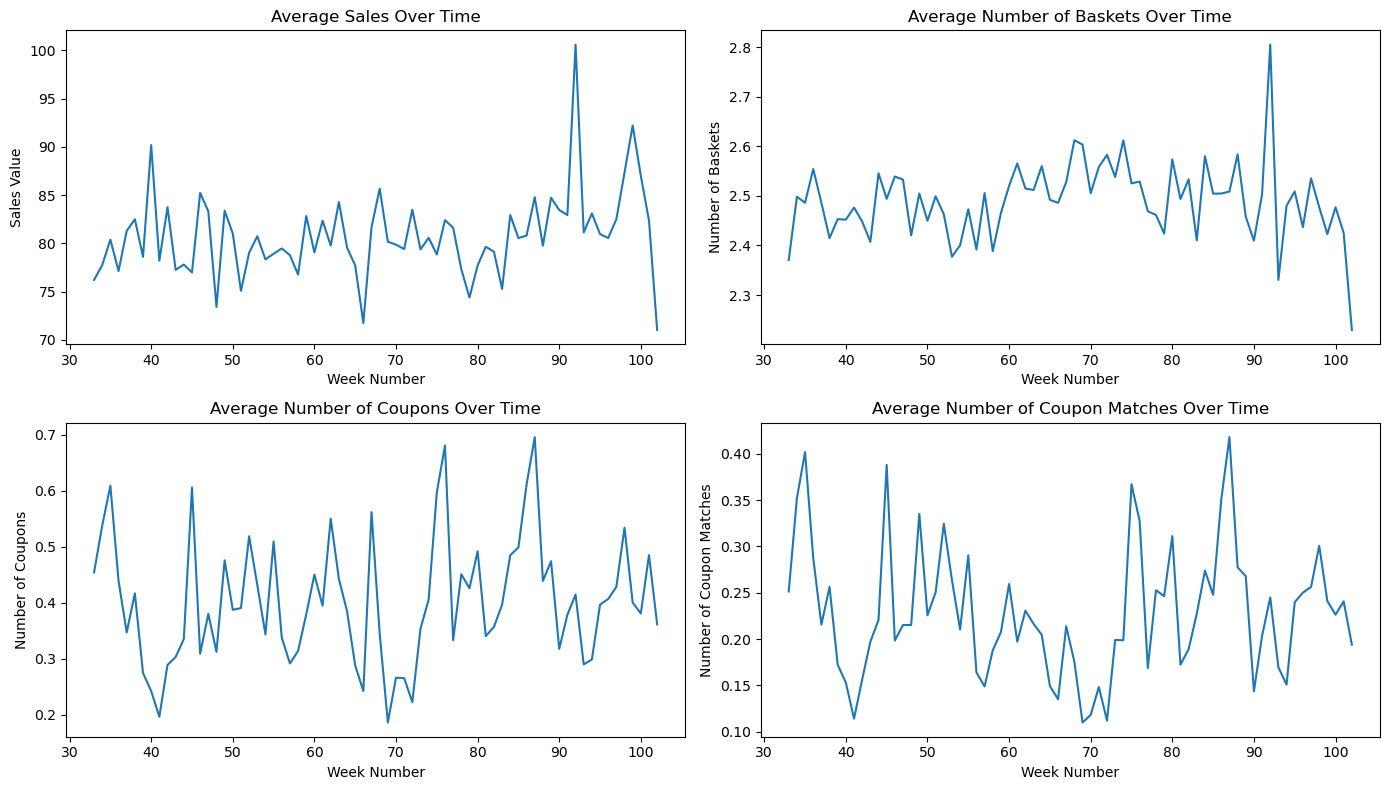

In [24]:
# Look at our metrics over time

# Group by week_no for average metrics over all households
weekly_metrics = transaction_demo_weekly.groupby('week_no').mean()

plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
weekly_metrics['total_sales_value'].plot()
plt.title('Average Sales Over Time')
plt.ylabel('Sales Value')
plt.xlabel('Week Number')

plt.subplot(2, 2, 2)
weekly_metrics['num_baskets'].plot()
plt.title('Average Number of Baskets Over Time')
plt.ylabel('Number of Baskets')
plt.xlabel('Week Number')

plt.subplot(2, 2, 3)
weekly_metrics['num_coupons'].plot()
plt.title('Average Number of Coupons Over Time')
plt.ylabel('Number of Coupons')
plt.xlabel('Week Number')

plt.subplot(2, 2, 4)
weekly_metrics['num_coupon_match'].plot()
plt.title('Average Number of Coupon Matches Over Time')
plt.ylabel('Number of Coupon Matches')
plt.xlabel('Week Number')

plt.tight_layout()
plt.show()


Which households spend the most each week?

In [25]:
top_sales_households = transaction_demo_weekly.sort_values(by='total_sales_value', ascending=False).head(10)
top_sales_households 

,household_key,week_no,total_sales_value,num_baskets,num_coupons,num_coupon_match,age,marital_status,income,homeowner,hh_comp,hh_size,kids
28053,1609,49,1283.33,4,8,4,3,0,1,0,1,4,2
40206,2322,44,763.79,9,0,0,3,2,4,0,4,0,3
14313,788,37,694.97,13,11,8,1,2,11,4,0,1,0
6128,346,83,681.58,1,0,0,5,0,9,0,2,1,3
38289,2208,59,673.99,6,0,0,2,2,9,4,0,2,1
25523,1453,92,655.15,16,1,1,3,0,1,0,1,2,0
410,19,85,639.87,8,1,0,2,1,2,4,3,0,3
28095,1609,92,628.56,7,0,0,3,0,1,0,1,4,2
41601,2400,52,601.58,11,37,26,2,0,6,0,1,2,0
34500,2012,92,592.03,10,0,0,3,0,6,3,4,1,3


In [26]:
# I'm curious what happened with household 2400 in week 52, as they came in 11 times that week and used 37 coupons + 26 coupon matches
hh2400_wk52 = transaction_data[(transaction_data['household_key'] == 2400) & (transaction_data['week_no'] == 52)]

hh2400_wk52.head(161)


,household_key,basket_id,store_id,day,week_no,trans_time,product_id,sales_value,amt_paid,retail_disc,coupon_disc,coupon_match_disc,day_of_week,hour
1154143,2400,32204748805,318,356,52,21:43:00,859191,2.50,2.01,-0.49,0.0,0.0,6,21
1154144,2400,32204748805,318,356,52,21:43:00,860776,0.79,0.79,0.00,0.0,0.0,6,21
1154145,2400,32204748805,318,356,52,21:43:00,866211,1.73,0.50,-1.23,0.0,0.0,6,21
1154146,2400,32204748805,318,356,52,21:43:00,911311,4.00,0.42,-3.58,0.0,0.0,6,21
1154147,2400,32204748805,318,356,52,21:43:00,918224,5.99,5.19,-0.80,0.0,0.0,6,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176305,2400,32269816089,410,362,52,14:34:00,13095419,5.99,5.99,0.00,0.0,0.0,5,14
1176306,2400,32269816089,410,362,52,14:34:00,13095474,5.00,4.01,-0.99,0.0,0.0,5,14
1176307,2400,32269816089,410,362,52,14:34:00,13095573,5.99,5.99,0.00,0.0,0.0,5,14
1177159,2400,32269905989,313,362,52,12:34:00,6533765,25.00,25.00,0.00,0.0,0.0,5,12


In [27]:
# how many unique products were purchased
unique_products_2400 = hh2400_wk52['product_id'].unique()
df_unique_products_2400 = pd.DataFrame(unique_products_2400, columns=['product_id'])


In [28]:
# what are these products?

query= """
SELECT u.*, p.department, p.commodity_desc, p.sub_commodity_desc
FROM df_unique_products_2400 AS u
LEFT JOIN product AS p
ON u.product_id = p.product_id;
"""

unique_products_2400_info = psql.sqldf(query, locals())
unique_products_2400_info

,product_id,department,commodity_desc,sub_commodity_desc
0,859191,PRODUCE,SALAD MIX,BLENDS
1,860776,PRODUCE,VEGETABLES - ALL OTHERS,CUCUMBERS
2,866211,PRODUCE,GRAPES,GRAPES WHITE
3,911311,GROCERY,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T
4,918224,GROCERY,FROZEN PIE/DESSERTS,FROZEN CREAM PIES
...,...,...,...,...
145,7166890,GROCERY,FROZEN PIZZA,SANDWICHES&HANDHELDS
146,9245348,DRUG GM,HAIR CARE PRODUCTS,HAIR CONDITIONERS AND RINSES
147,9803395,GROCERY,REFRGRATD DOUGH PRODUCTS,REFRIGERATED COOKIES-CHUB
148,12810409,MEAT,PORK,ENHANCED


In [29]:
print('unique departments: ',unique_products_2400_info.department.nunique())
print('unique product categories: ', unique_products_2400_info.commodity_desc.nunique())
print('unique product descriptions:',unique_products_2400_info.sub_commodity_desc.nunique())

unique departments:  8
unique product categories:  57
unique product descriptions: 81


### 2.6.2 Prepare table for modeling  <a id='2.6.2'></a>

In [30]:
transaction_demo_weekly.head()


,household_key,week_no,total_sales_value,num_baskets,num_coupons,num_coupon_match,age,marital_status,income,homeowner,hh_comp,hh_size,kids
0,1,33,123.86,1,7,5,5,0,8,0,2,1,3
1,1,34,42.80,2,0,0,5,0,8,0,2,1,3
2,1,36,80.45,2,0,0,5,0,8,0,2,1,3
3,1,38,72.82,1,3,1,5,0,8,0,2,1,3
4,1,40,113.07,2,7,6,5,0,8,0,2,1,3


Create a table weekly_data where the household_key is not included. This is a table of the total sales from each household by week, but without a specific identifier. 

In [31]:
weekly_data = transaction_demo_weekly[['week_no','total_sales_value', 'num_baskets', 'num_coupons', 'num_coupon_match', 'age','marital_status','income','homeowner','hh_comp', 'hh_size', 'kids']]

In [32]:
weekly_data

,week_no,total_sales_value,num_baskets,num_coupons,num_coupon_match,age,marital_status,income,homeowner,hh_comp,hh_size,kids
0,33,123.86,1,7,5,5,0,8,0,2,1,3
1,34,42.80,2,0,0,5,0,8,0,2,1,3
2,36,80.45,2,0,0,5,0,8,0,2,1,3
3,38,72.82,1,3,1,5,0,8,0,2,1,3
4,40,113.07,2,7,6,5,0,8,0,2,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...
43224,96,6.68,1,0,0,1,2,11,4,1,2,0
43225,97,210.83,1,0,0,1,2,11,4,1,2,0
43226,100,11.87,1,0,0,1,2,11,4,1,2,0
43227,101,280.92,1,4,1,1,2,11,4,1,2,0


## 2.7 Initial Models:<a id='2.7'></a>

### 2.7.1 KNN <a id='2.7.1'></a>

In [33]:
# Divide data into Y and y.
X = weekly_data.drop(['total_sales_value'], axis=1)
y = weekly_data['total_sales_value']

# Identify week that is at the 80% mark, because I don't want to split data in the middle of a week.
unique_week = weekly_data['week_no'].unique()
threshold_week = unique_week[int(0.8 * len(unique_week))]
print('threshold week: ', threshold_week)


threshold week:  75


In [34]:

# Figure out what weekly_data goes in train/test based on threshold week
train_indices = weekly_data[weekly_data['week_no'] < threshold_week].index
test_indices = weekly_data[weekly_data['week_no'] >= threshold_week].index

# Splitting the data
X_train, X_test = X.loc[train_indices].drop('week_no', axis=1), X.loc[test_indices].drop('week_no', axis=1)
y_train, y_test = y.loc[train_indices], y.loc[test_indices]


In [35]:
print('Train shape: ', X_train.shape)
print('Test shape: ',X_test.shape)
print('% data in test set: ', (324966/1094165)*100)

Train shape:  (25771, 10)
Test shape:  (17458, 10)
% data in test set:  29.699908149136554


In [36]:
# What is the average sales_value of a transaction? This will help us determine how large our error is.
train_mean = y_train.mean()
train_mean

80.01000892475972

In [37]:
# standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:
# Train model
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

KNeighborsRegressor()

In [39]:
# predict
y_pred_knn = knn.predict(X_test_scaled)


In [40]:
mape = mean_absolute_percentage_error(y_test, y_pred_knn)
print(f"MAPE: {mape:.2f}%")



MAPE: 2608569104822.60%


This is huge! Moving on...

### 2.7.2 OLS Model <a id='2.7.2'></a>

Although a linear model won't likely work very well with this data, it is easily interpretable, so I like it as one of my baseline models.

In [41]:
X_train_with_const = sm.add_constant(X_train)
X_test_with_const = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_with_const).fit()

print(model.summary())

y_pred_train = model.predict(X_train_with_const)
y_pred_test = model.predict(X_test_with_const)


                            OLS Regression Results                            
Dep. Variable:      total_sales_value   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     845.8
Date:                Sun, 15 Oct 2023   Prob (F-statistic):               0.00
Time:                        12:01:01   Log-Likelihood:            -1.4289e+05
No. Observations:               25771   AIC:                         2.858e+05
Df Residuals:                   25760   BIC:                         2.859e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               57.0904      2.288  

The R squared indicates that the model's features contribute toward our target, and most of the features are statistically significant.

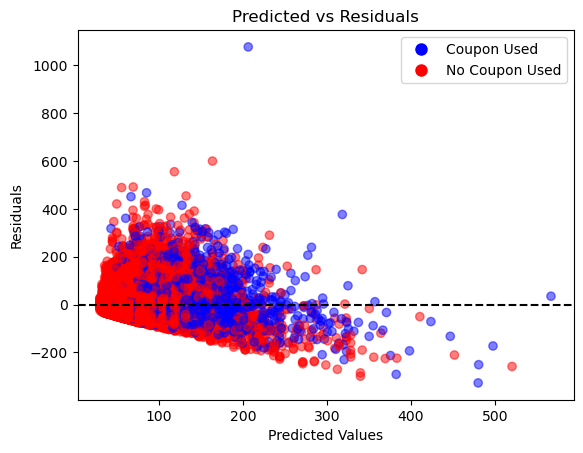

In [43]:
# CALCULATE RESIDUALS
# COLOR CODE BY COUPON USER VS NOT COUPON USER - BY WEEK OR IF EVER USE COUPON

colors = np.where((X_train['num_coupons'] > 0) | (X_train['num_coupon_match'] > 0), 'blue', 'red')

plt.scatter(predicted_values, residuals, c=colors, alpha=0.5)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Predicted Values')
plt.title('Predicted vs Residuals')
plt.ylabel('Residuals')
plt.legend(handles=[Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Coupon Used'),
                    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='No Coupon Used')],
           loc='upper right')
plt.show()


There is an extreme outier with a very high residual, I'd like to look at this and probably remove.

In [44]:
# Almost all of our residuals are under 500, so I'll remove the few over that amount. 
outliers = np.where(residuals > 500)
outliers


(array([16722, 22840, 23973], dtype=int64),)

In [45]:
# Remove these outliers
# Assuming outliers is a tuple with the indices as its first element
outlier_indices = outliers[0]

# Drop the outliers from X_train
X_train = X_train.drop(index=outlier_indices)

# Drop the outliers from y_train
y_train = y_train.drop(index=outlier_indices)


<b>Retrain</b>

In [46]:
# Add constant to X_train
X_train_const = sm.add_constant(X_train)

# Rebuild the model using cleaned data
model_cleaned = sm.OLS(y_train, X_train_const).fit()

# Predict values on cleaned X_train
predicted_values_cleaned = model_cleaned.predict(X_train_const)

# Compute the residuals using cleaned data
residuals_cleaned = y_train - predicted_values_cleaned



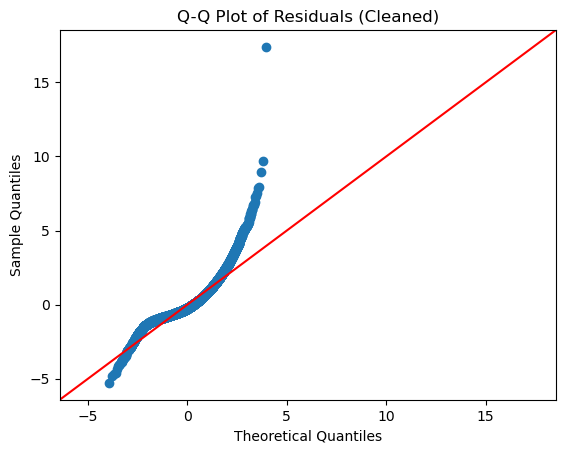

In [47]:
# Q-Q plot using cleaned residuals
sm.qqplot(residuals_cleaned, line='45', fit=True)
plt.title('Q-Q Plot of Residuals (Cleaned)')
plt.show()


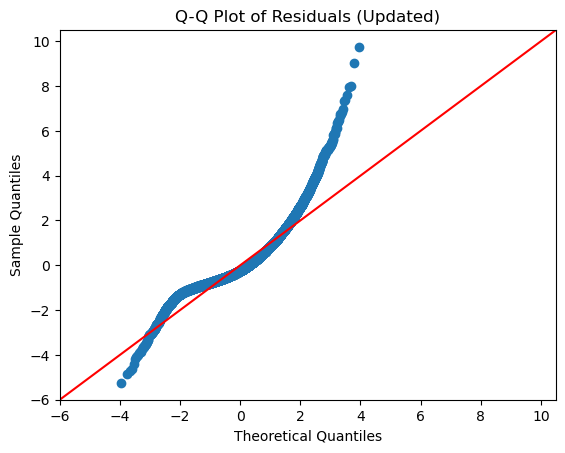

In [48]:
# There is still an outlier... let's figure that out. 

# Identify the outlier in the cleaned residuals
outlier_index = residuals_cleaned.idxmax()

# Drop the outlier from X_train and y_train
X_train = X_train.drop(outlier_index)
y_train = y_train.drop(outlier_index)

# Rebuild the model using the updated datasets
X_train_const = sm.add_constant(X_train)
model_updated = sm.OLS(y_train, X_train_const).fit()

# Predict values using the updated model
predicted_values_updated = model_updated.predict(X_train_const)

# Compute the residuals using the updated data
residuals_updated = y_train - predicted_values_updated

# Q-Q plot using updated residuals
sm.qqplot(residuals_updated, line='45', fit=True)
plt.title('Q-Q Plot of Residuals (Updated)')
plt.show()


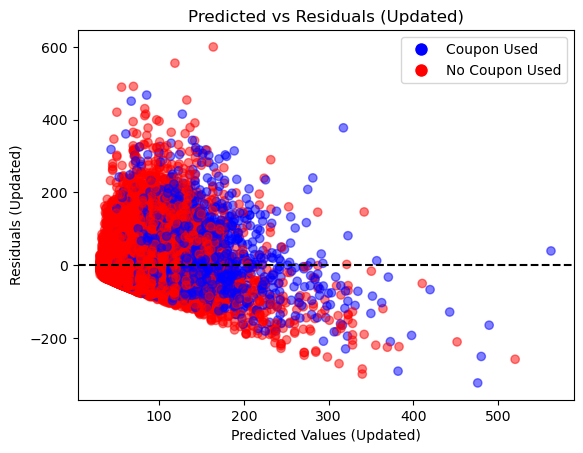

In [49]:
# Replot predicted vs residuals 

# Use the updated predicted values and residuals
colors_updated = np.where((X_train['num_coupons'] > 0) | (X_train['num_coupon_match'] > 0), 'blue', 'red')

plt.scatter(predicted_values_updated, residuals_updated, c=colors_updated, alpha=0.5)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Predicted Values (Updated)')
plt.title('Predicted vs Residuals (Updated)')
plt.ylabel('Residuals (Updated)')
plt.legend(handles=[Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Coupon Used'),
                    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='No Coupon Used')],
           loc='upper right')
plt.show()

There is definitely a pattern here with coupons/no coupons being used, it looks like coupon users are likely to spend more. I may want to do PCA to see if I can address this weird tilt.

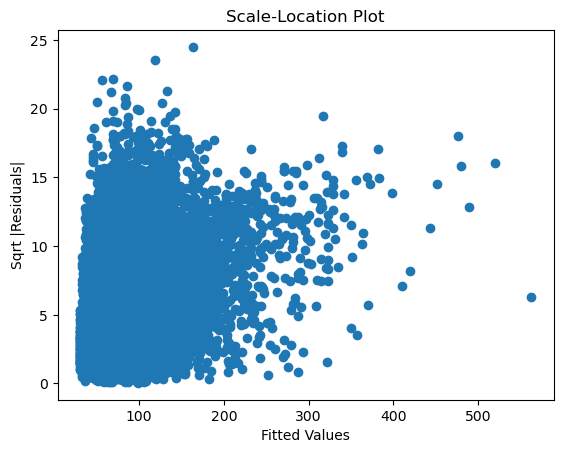

In [50]:
# Scale location plot

plt.scatter(predicted_values_updated, np.sqrt(np.abs(residuals_updated)))
plt.xlabel('Fitted Values')
plt.ylabel('Sqrt |Residuals|')
plt.title('Scale-Location Plot')
plt.show()


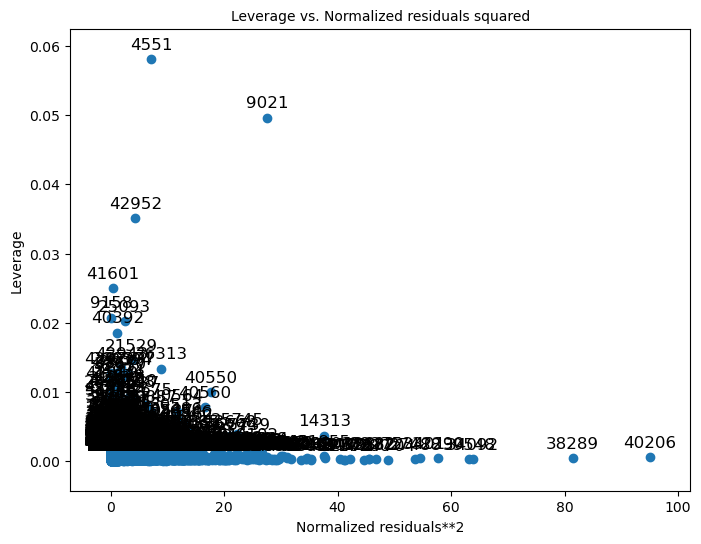

In [51]:
# Leverage vs normalized residuals squared
# leverage helps us understand how far away the independent variable values of an observation are from those 
#of the other observations

X_train_const = sm.add_constant(X_train)
model_cleaned = sm.OLS(y_train, X_train_const).fit()

fig, ax = plt.subplots(figsize=(8,6))
sm.graphics.plot_leverage_resid2(model_cleaned, ax=ax, alpha=0.5)

# Reduce the font size of the labels:
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(10)

plt.show()


<b>I'd like to find out what's going on with the high leverage points</b>

In [52]:
transaction_demo_weekly.loc[4551]

household_key        248.00
week_no               33.00
total_sales_value    324.61
num_baskets            1.00
num_coupons           32.00
num_coupon_match       8.00
age                    2.00
marital_status         0.00
income                 1.00
homeowner              0.00
hh_comp                1.00
hh_size                3.00
kids                   1.00
Name: 4551, dtype: float64

In [53]:
transaction_demo_weekly.loc[9021]

household_key        490.0
week_no               49.0
total_sales_value    152.5
num_baskets            1.0
num_coupons           45.0
num_coupon_match      36.0
age                    2.0
marital_status         0.0
income                10.0
homeowner              0.0
hh_comp                1.0
hh_size                4.0
kids                   2.0
Name: 9021, dtype: float64

In [54]:
transaction_demo_weekly.loc[42952]

household_key        2489.00
week_no                45.00
total_sales_value     314.27
num_baskets             1.00
num_coupons            41.00
num_coupon_match       31.00
age                     2.00
marital_status          0.00
income                  9.00
homeowner               0.00
hh_comp                 2.00
hh_size                 1.00
kids                    3.00
Name: 42952, dtype: float64

In [55]:
transaction_demo_weekly.loc[41601]

household_key        2400.00
week_no                52.00
total_sales_value     601.58
num_baskets            11.00
num_coupons            37.00
num_coupon_match       26.00
age                     2.00
marital_status          0.00
income                  6.00
homeowner               0.00
hh_comp                 1.00
hh_size                 2.00
kids                    0.00
Name: 41601, dtype: float64

The high leverage points used a lot more coupons than most customers, and had sales_values on the higher side. I will remove these.

In [56]:
# Print out high leverage indexes

# Calculate the influence of each observation
influence = OLSInfluence(model_cleaned)

# Get the leverage (hat values) for each observation
leverage = influence.hat_matrix_diag

# Identify rows where the leverage exceeds 0.02
high_leverage_points = np.where(leverage > 0.02)[0]

# Sort these points by their leverage values in descending order
sorted_indices = high_leverage_points[np.argsort(-leverage[high_leverage_points])]

# Print the sorted indices and their corresponding leverage values
for index in sorted_indices:
    print(f"Row index: {index}, Leverage: {leverage[index]:.4f}")


Row index: 2701, Leverage: 0.0581
Row index: 5379, Leverage: 0.0496
Row index: 25600, Leverage: 0.0352
Row index: 24817, Leverage: 0.0250
Row index: 5463, Leverage: 0.0207
Row index: 14977, Leverage: 0.0202


In [57]:
# What is the mean leverage of my data?

average_leverage = (X_train.shape[1]+ 1)/transaction_demo_weekly.shape[0]

print('average_leverage in data: {:.4f}'.format(average_leverage))

# Rule of thumb for high leverage is that 3x the average leverage is considered high.

high_leverage = average_leverage * 3

print('high leverage cutoff: {:.4f}'.format(high_leverage))

#Let's look at my selected cutoff above, where I pulled out the points with more than 0.02 leverage.

highest_leverage = 0.0581/average_leverage
print('Highest leverage point is {:.4f}'.format(highest_leverage), 'times higher than the average')


average_leverage in data: 0.0003
high leverage cutoff: 0.0008
Highest leverage point is 228.3277 times higher than the average


### Discussion:

I've figured out that coupon superusers (using ~40 coupons a week) are likely the ones that are skewing the data as they have the highest residuals, so I clearly need to investigate this more. 

I now want to look at sales by coupon users vs not coupon users

## 2.8 Additional analysis on coupons users vs. not coupon users  <a id='2.8'></a>

<b>Look into sales by coupon users vs not coupon users </b>

In [58]:
transaction_demo_weekly.columns

Index(['household_key', 'week_no', 'total_sales_value', 'num_baskets',
       'num_coupons', 'num_coupon_match', 'age', 'marital_status', 'income',
       'homeowner', 'hh_comp', 'hh_size', 'kids'],
      dtype='object')

In [59]:
# which households use coupons (ever):

households_using_coupons = transaction_demo_weekly[(transaction_demo_weekly['num_coupons'] > 0) | 
                                                  (transaction_demo_weekly['num_coupon_match'] > 0)]

# Extract unique household_keys from the filtered dataframe
unique_coupon_households = households_using_coupons['household_key'].unique()

total_households = transaction_demo_weekly.household_key.nunique()
print('Total number of households: ', total_households)

coupon_household_count = len(unique_coupon_households)
print('households that use coupons: ',coupon_household_count)

no_coupon_household_count = total_households - coupon_household_count
print ('Households that do not use coupons: ', no_coupon_household_count)

Total number of households:  801
households that use coupons:  691
Households that do not use coupons:  110


It looks like most households use coupons at least some of the time!

In [60]:
# Split df into coupon users and not coupon users dataframes

# Create a dataframe for households that ever use coupons
coupon_weekly= transaction_demo_weekly[transaction_demo_weekly['household_key'].isin(unique_coupon_households)]

# Create a dataframe for households that never use coupons
no_coupon_weekly= transaction_demo_weekly[~transaction_demo_weekly['household_key'].isin(unique_coupon_households)]

print(f"Number of records in coupon_weekly: {len(coupon_weekly)}")
print(f"Number of records in no_coupon_weekly: {len(no_coupon_weekly)}")


Number of records in coupon_weekly: 37967
Number of records in no_coupon_weekly: 5262


In [62]:
# drop num_coupons, num_baskets, num_coupon_match
no_coupon_weekly=no_coupon_weekly.drop(columns=['num_baskets','num_coupons','num_coupon_match'], axis=1 ) 

coupon_weekly = coupon_weekly.drop(columns=['num_baskets','num_coupons','num_coupon_match'], axis=1 ) 

In [63]:
coupon_weekly.columns

Index(['household_key', 'week_no', 'total_sales_value', 'age',
       'marital_status', 'income', 'homeowner', 'hh_comp', 'hh_size', 'kids'],
      dtype='object')

<b> I now have 2 tables: coupon_weekly, which includes weekly transaction data for all households that use coupons (at any point), as well as no_coupon_weekly, which includes weekly transaction data for households that never use coupons. Now I want to look at weekly sales for households and track sales growth for coupon using households </b>

In [64]:
# Calculate week-over-week growth in sales value by household
coupon_weekly = coupon_weekly.sort_values(by=['household_key', 'week_no'])
coupon_weekly['sales_growth'] = coupon_weekly.groupby('household_key')['total_sales_value'].pct_change() * 100

# Calculate the average week-over-week sales growth by household
avg_growth_by_household = coupon_weekly.groupby('household_key')['sales_growth'].mean().reset_index()


In [65]:
# Calculate average sales volume by household
avg_sales_by_household = coupon_weekly.groupby('household_key')['total_sales_value'].mean().reset_index()
avg_sales_by_household.rename(columns={'total_sales_value': 'avg_sales_value'}, inplace=True)


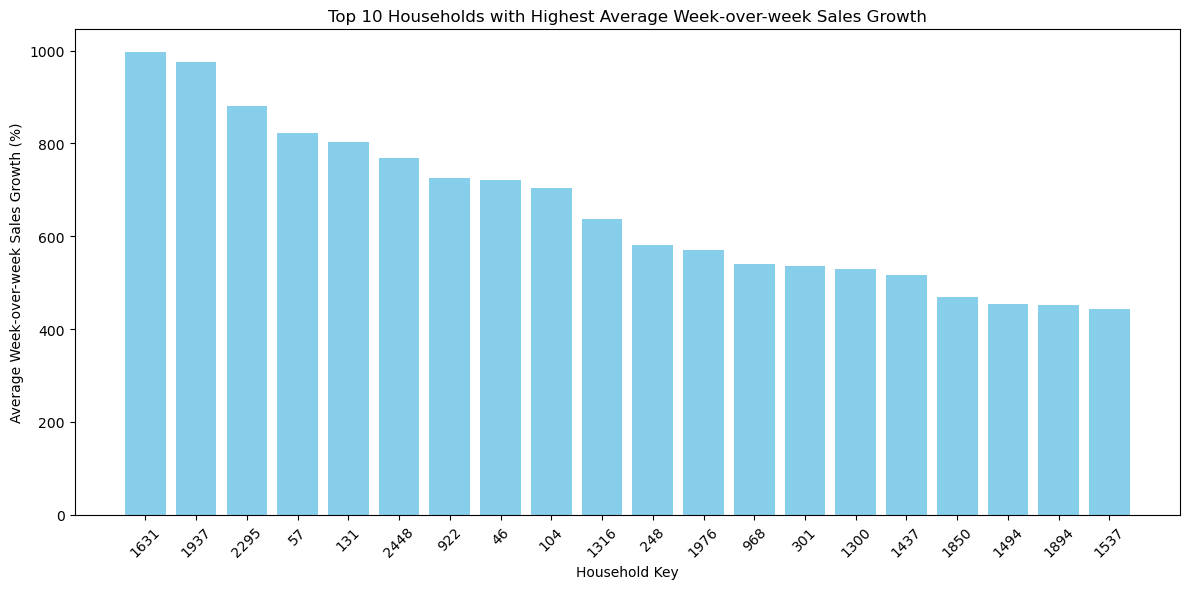

In [66]:
# Average week over week sales growth per household

# Sort households by average week-over-week sales growth and select top 20
top_20_growth_households = avg_growth_by_household.sort_values(by='sales_growth', ascending=False).head(20)

plt.figure(figsize=(12, 6))
plt.bar(top_20_growth_households['household_key'].astype(str), top_20_growth_households['sales_growth'], color='skyblue')
plt.xlabel('Household Key')
plt.ylabel('Average Week-over-week Sales Growth (%)')
plt.title('Top 10 Households with Highest Average Week-over-week Sales Growth')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [67]:
# I'd like to see which households have the highest week over week growth.
avg_growth_by_household.sort_values(by='sales_growth', ascending=False).head(10)

,household_key,sales_growth
437,1631,996.052864
517,1937,974.984399
627,2295,879.624032
21,57,823.199737
42,131,802.659222
676,2448,769.472495
271,922,724.944502
17,46,721.864266
31,104,704.138037
356,1316,638.172084


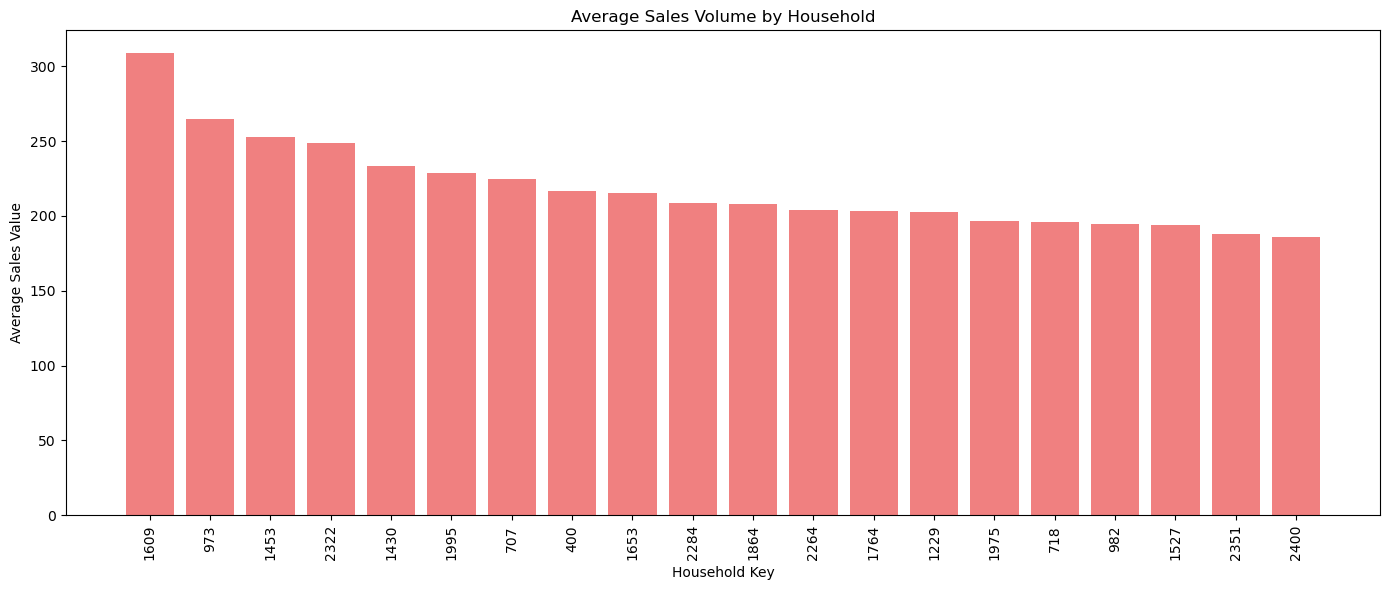

In [68]:
# Average sales volume by household

#Sort households by average week-over-week sales growth and select top 20
top_20_sales_households = avg_sales_by_household.sort_values(by='avg_sales_value', ascending=False).head(20)

plt.figure(figsize=(14, 6))
plt.bar(top_20_sales_households['household_key'].astype(str), top_20_sales_households['avg_sales_value'], color='lightcoral')
plt.xlabel('Household Key')
plt.ylabel('Average Sales Value')
plt.title('Average Sales Volume by Household')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [69]:
# Calculate week over week sales growth for each household
coupon_weekly = coupon_weekly.sort_values(by=['household_key', 'week_no'])
coupon_weekly['week_over_week'] = coupon_weekly.groupby('household_key')['total_sales_value'].pct_change() + 1

sales_growth = coupon_weekly.groupby('household_key')['week_over_week'].mean()

avg_sales_volume = coupon_weekly.groupby('household_key')['total_sales_value'].mean()


<b>Create a plot of coupon users sales volume vs sales growth, and split into quadrants to make recommendations on which customers would be good investments to send coupons to in order to bookst sales</b>

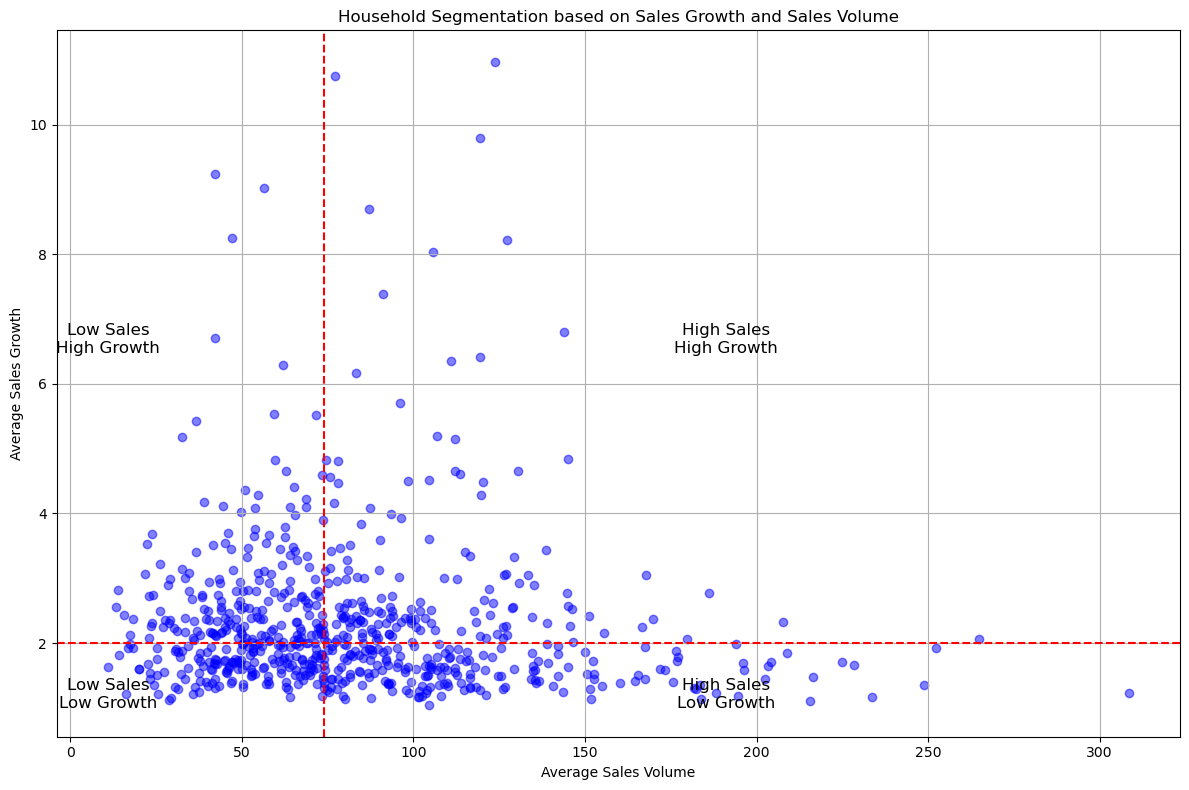

In [70]:
df_metrics = pd.DataFrame({
    'avg_sales_volume': avg_sales_volume,
    'sales_growth': sales_growth
})

# Calculate medians for both metrics
median_volume = df_metrics['avg_sales_volume'].median()
median_growth = df_metrics['sales_growth'].median()

plt.figure(figsize=(12, 8))
plt.scatter(df_metrics['avg_sales_volume'], df_metrics['sales_growth'], c='blue', alpha=0.5)
plt.axvline(median_volume, color='red', linestyle='--')
plt.axhline(median_growth, color='red', linestyle='--')

plt.title('Household Segmentation based on Sales Growth and Sales Volume')
plt.xlabel('Average Sales Volume')
plt.ylabel('Average Sales Growth')
plt.grid(True)

# Quadrant Labels
plt.text(df_metrics['avg_sales_volume'].min(), median_growth / 2, 'Low Sales\nLow Growth', fontsize=12, ha='center')
plt.text(df_metrics['avg_sales_volume'].min(), (df_metrics['sales_growth'].max() + median_growth) / 2, 'Low Sales\nHigh Growth', fontsize=12, ha='center')
plt.text((df_metrics['avg_sales_volume'].max() + median_volume) / 2, median_growth / 2, 'High Sales\nLow Growth', fontsize=12, ha='center')
plt.text((df_metrics['avg_sales_volume'].max() + median_volume) / 2, (df_metrics['sales_growth'].max() + median_growth) / 2, 'High Sales\nHigh Growth', fontsize=12, ha='center')

plt.tight_layout()
plt.show()


<b> split the data into different dataframes so that I can isolate the households with low sales/high growth, high sales/low growth, and high sales/high growth, as these would be great customers to focus on for marketing campaigns. There's not much point in focusing on low sales/low growth customers </b>

In [71]:
# Determine the median values for average sales volume and sales growth
median_sales_volume = df_metrics['avg_sales_volume'].median()
median_sales_growth = df_metrics['sales_growth'].median()

# Segment data based on the medians

# Bottom left quadrant (low average sales volume, low growth)
low_sales_low_growth = df_metrics[(df_metrics['avg_sales_volume'] <= median_sales_volume) & 
                         (df_metrics['sales_growth'] <= median_sales_growth)]

# Top left quadrant (low average sales volume, high growth)
low_sales_high_growth = df_metrics[(df_metrics['avg_sales_volume'] <= median_sales_volume) & 
                      (df_metrics['sales_growth'] > median_sales_growth)]

# Bottom right quadrant (high average sales volume, low growth)
high_sales_low_growth = df_metrics[(df_metrics['avg_sales_volume'] > median_sales_volume) & 
                          (df_metrics['sales_growth'] <= median_sales_growth)]

# Top right quadrant (high average sales volume, high growth)
high_sales_high_growth = df_metrics[(df_metrics['avg_sales_volume'] > median_sales_volume) & 
                       (df_metrics['sales_growth'] > median_sales_growth)]


In [72]:
# Look at the high sales/high growth households, as these will likely be the most profitable households to focus on

high_sales_high_growth.sort_values(by='sales_growth', ascending=False)

,avg_sales_volume,sales_growth
household_key,,
1631,123.674143,10.960529
1937,77.042462,10.749844
2295,119.280217,9.796240
2448,87.054127,8.694725
46,127.237460,8.218643
...,...,...
304,89.190435,2.040348
361,99.569677,2.023637
22,74.754426,2.022541


## 2.9 Exports<a id='2.9'></a>

In [76]:

transaction_demo.to_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\exports_2\transaction_demo.csv", index=False)
transaction_demo_weekly.to_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\exports_2\transaction_demo_weekly.csv", index=False)
weekly_data.to_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\exports_2\weekly_data.csv", index=False)
coupon_weekly.to_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\exports_2\coupon_weekly.csv", index=False)
high_sales_high_growth.to_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\results\high_sales_high_growth.csv", index=False)
low_sales_low_growth.to_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\results\low_sales_low_growth.csv", index=False)
low_sales_high_growth.to_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\results\low_sales_high_growth.csv", index=False)
high_sales_low_growth.to_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\results\high_sales_low_growth.csv", index=False)



## 2.10 Discussion & Next Steps <a id='2.10'></a>

In this notebook, I built a table that included demographics and binary coupon use data, and I mapped the categorical demographics columns to be numbers instead of strings: 

age:

* 19-24 => 0
* 25-34 => 1
* 35-44 => 2
* 45-54 => 3
* 55-64 => 4
* 65+ => 5

marital_status:

* Married => 0
* Single => 1
* Unknown => 2

income:

* 100-124K => 0
* 125-149K => 1
* 15-24K => 2
* 150-174K => 3
* 175-199K => 4
* 200-249K => 5
* 25-34K => 6
* 250K+ => 7
* 35-49K => 8
* 50-74K => 9
* 75-99K => 10
* Under 15K => 11

homeowner:

* Homeowner => 0
* Probable Owner => 1
* Probable Renter => 2
* Renter => 3
* Unknown => 4

hh_comp:

* 1 Adult Kids => 0
* 2 Adults Kids => 1
* 2 Adults No Kids => 2
* Single Female => 3
* Single Male => 4
* Unknown => 5

hh_size:

* 1 => 0
* 2 => 1
* 3 => 2
* 4 => 3
* 5+ => 4

kids:

* 1 => 0
* 2 => 1
* 3+ => 2

I aggregated the data so that there were total sales and coupon counts for each day, for each customer, and I ended up with a table with 43229 rows. I also only included the data from the times when the there were active marketing campaigns, because the first 30 weeks appeared to be missing data, and it looks like they weren’t collecting data from all households yet. 
I looked at average sales, number of baskets, and number of coupons over time and I see for all of these there was a peak around week 90. I also identified the households/weeks with the highest total_sales_value.

To do the train/test split, I did an 80/20 split, I kept the weeks in order, and I made sure the split didn’t happen in the middle of a week. I did drop the week_no from the table for modeling after this, and determined that the mean sales_value in the training set is $80.01. 

I first tried K Nearest Neighbors, but ended up with a MAPE of 2608569104822.60%.

Next, I tried an OLS model because it is highly interpretable. From this, I got an R-squared of 0.247, and significant P values for all of the demographics except number of kids and marital_status. The predicted vs residuals plot had a strange tilt to it, but overall the higher the predicted values were, the lower the residuals. There was one extreme outlier that had a very high residual. I was also able to see that the predicted sales values for ‘no coupon used’ tended to be lower than for coupon users. The ‘Leverage vs Normalized Residuals Squared’ plot was interesting, and I was able to see that overall there were a lot of points with high leverage, and 6 that had leverage over 0.02, whereas the average leverage in the data was 0.0003. I looked at all of these rows, and they all used abnormally high quantities of coupons. From this, it appears that coupon ‘super users’, though rare, contribute greatly to high residuals and likely the cause of high error in the KNN model. 

I also tried splitting the data into 2: households that use coupons, and households that never use coupons. I found that out of 801 households, 691 use coupons, and 110 do not. I identified the households that have the highest week-over-week growth, and also the households with the highest average sales volume. I plotted the average sales volume vs average sales growth, and divided it up into quadrants. From this, I can identify which households marketing campaigns should likely focus on: the ones that have high sales/high growth, low sales/high growth, and possibly the high sales/low growth.  



<b>Next Steps </b>

Next, I want to include the coupon redemption rate in the table and remove the other coupon columns, try KNN and XG Boost again, and do a 90/10 test-train split. The next notebook is titled '3 Dunnhumby Modeling- Feature Engineering & Clustering'.